In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import scipy.stats as sp

path = os.path.abspath("Data")+os.path.sep
filename = path + "water_quality.csv"

In [2]:
# find the degree of the polynomial that better suits the data.
# iterative approach: increase the polynomial degree until the drop of the squared error is big enough.
# (i.e if the SE is reduced by a big amount continue, otherwise settle for the degree you have )
# maybe it avoids overfitting ???
# abs(SE(k) - SE(k+1)) < epsilon
def selective_fit(xs, ys):
    epsilon = 1 # to check convergence
    squared_error = float('inf') 
    converged = False
    degree = 1
    coefficients = []
    while converged is False:
        coeff_i, se_i, _, _, _ = np.polyfit(xs, ys, degree, full=True)
        if(abs(se_i - squared_error) < epsilon):
            converged = True
        else: 
            coefficients = coeff_i
            squared_error = se_i
            degree += 1
    
    return coefficients, squared_error, degree-1

In [3]:
# fits the scatter points with many polynomial degrees minimizing the squared error, which is reported.
# the length of the 'colors' array determines the number of polynomial degrees to try
def fit_scatter_and_plot(var_x, var_y, xs, ys, unit_x, unit_y, colors):
    #for c, degree in zip(colors, range(1, len(colors) + 1, 1)):
    #coefficients, least_squared_error, _, _, _ = np.polyfit(xs, ys, degree, full=True)
    coefficients, squared_error, degree = selective_fit(xs, ys)
    p = np.poly1d(coefficients)
    label = '%d$^\circ$, SE = %.2f' %(degree, squared_error)
    plt.plot(np.unique(xs), p(np.unique(xs)), 'g' , label=label)
    
    # report correlation coefficients
    rcoeff = np.corrcoef(xs,ys) # Pearson
    rcoeff = rcoeff[0][1]
    rho, p_value = sp.spearmanr(xs, ys) # rank-order correlation, p_value to test for non-correlation
    plt.plot([], [], 'white', label=r'R = %.2f, $\rho$ = %.2f' % (rcoeff, rho)) # plot empty set just for the labels
    
    plt.scatter(xs, ys)
    plt.xlabel(var_x + ' ' + unit_x)
    plt.ylabel(var_y + ' ' + unit_y)
    plt.title(var_x + ' and ' + var_y)
    plt.legend(bbox_to_anchor = (1, 1), loc=2)

In [4]:
# further process of the data frame
def split_on_variables_then_merge_data_frames_on_keys(frame, keys, var1, var2):
    selected_rows = frame[(frame['determinand.label'] == var1) | (frame['determinand.label'] == var2)]
    left_frame = selected_rows[selected_rows['determinand.label'] == var1]
    right_frame = selected_rows[selected_rows['determinand.label'] == var2]
    merged = pd.merge(left_frame, right_frame, on=keys)
    return merged

In [5]:
import operator
data = pd.read_csv(filename)
df = data[['determinand.label', 'result', 'determinand.unit.label', 'water body']]

grouped = df.groupby(['determinand.label', 'determinand.unit.label'])['result'].agg([pd.np.min, pd.np.max, pd.np.mean, pd.np.std, 'count'])

filtered = grouped[grouped['count'] > 15]
pd.DataFrame.sort_values(filtered, "count", ascending=False).head(n=7)

,,amin,amax,mean,std,count
determinand.label,determinand.unit.label,,,,,
Ammonia(N),mg/l,0.030,9.170,0.577450,1.457473,60
N Oxidised,mg/l,0.620,7.290,2.721636,1.856487,55
Nitrite-N,mg/l,0.004,0.208,0.029571,0.038017,55
Nitrate-N,mg/l,0.613,7.190,2.692436,1.833456,55
Temp Water,cel,6.700,21.600,14.259615,2.894570,52
Orthophospht,mg/l,0.062,0.973,0.232942,0.164296,52
pH,phunits,6.850,8.360,7.956304,0.270320,46


In [6]:
# process data frame, select columns of interest.
df2 = data[['determinand.label', 'result', 'determinand.unit.label', 'sample.sampleDateTime', 'Waterbody ID']]

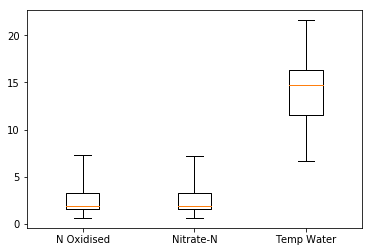

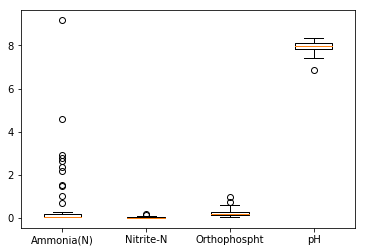

In [7]:
# box plots, to contain the lists of values of the 7 variables
# 2 different box plots to capture the different scales of the variables
vars_1 = ['N Oxidised', 'Nitrate-N', 'Temp Water'] # big spread
vars_2 = ['Ammonia(N)', 'Nitrite-N', 'Orthophospht', 'pH'] # small spread
box_data1, box_data2 = [], []
for var_name in vars_1:
    box_data1.append(df2[df2['determinand.label'] == var_name]['result'])
    
for var_name in vars_2:
    box_data2.append(df2[df2['determinand.label'] == var_name]['result'])    
# returns a dictionary with keys: boxes, medians, whiskers, caps, fliers, means
dict_stats1 = plt.boxplot(box_data1, whis=3, labels=vars_1, vert=True) 
plt.show()
dicts_stats2 = plt.boxplot(box_data2, whis=3, labels=vars_2, vert=True)
plt.show()

# TODO
# don't you know what's a fucking boxplot? --->>> http://www.physics.csbsju.edu/stats/box2.html
# 1. using the key 'fliers' remove outliers from data points.
# 2. fit polynomial and compute correlation after the outliers are removed.
# 3. in the scatter plots still plot the outliers (different color) along with the normal points.

In [8]:
#for pair in intertools.combinations(variables):
#    print(pair)
#from sklearn.metrics import r2_score
variables = ['Ammonia(N)', 'N Oxidised', 'Nitrate-N', 'Nitrite-N', 'Orthophospht', 'pH', 'Temp Water']
keys = ['Waterbody ID', 'sample.sampleDateTime']
colors = ['r', 'g', 'b']
figure = 0

for x in variables:
    for y in variables:
        if(x != y):
            merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=x, var2=y)
            # get the ingredients to produce the plot
            xs, ys = merged_df['result_x'], merged_df['result_y']
            var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
            unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]

            plt.figure(figure)
            figure+=1
            fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

/home/carlo/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [9]:
# create a left and right data frame (to separate the variables) and then do an inner join 
# on the water body and date.
# (i.e. pick the measurements that were taken at the same time and place)

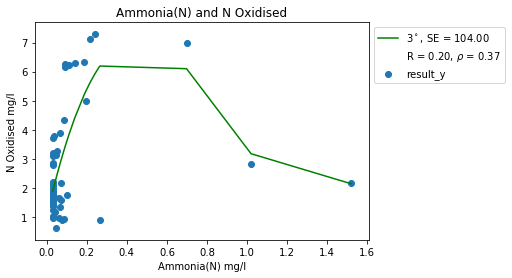

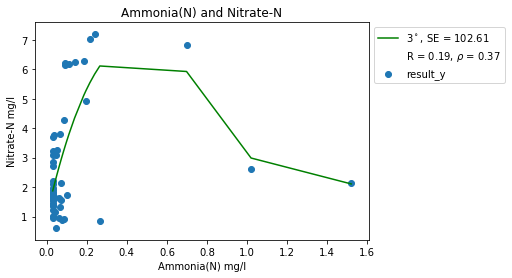

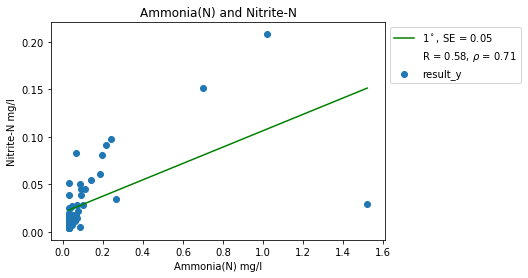

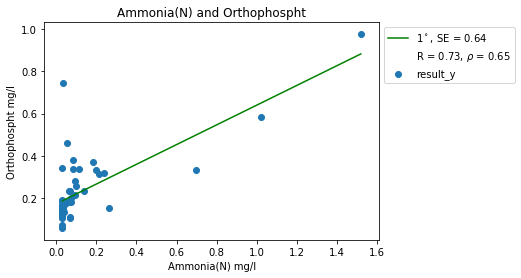

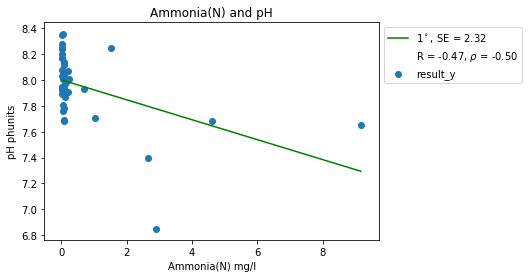

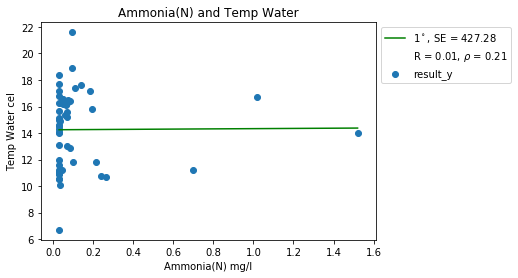

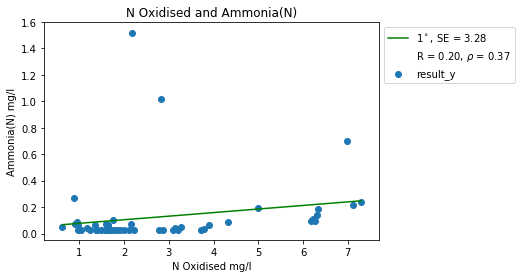

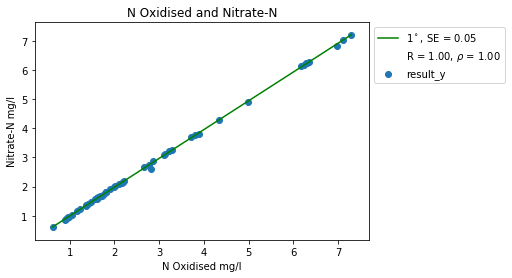

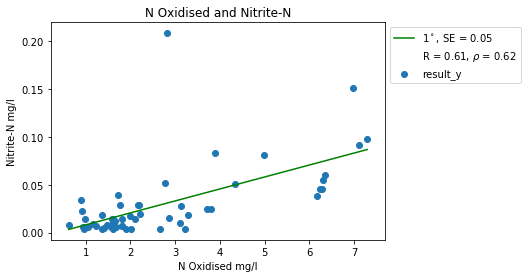

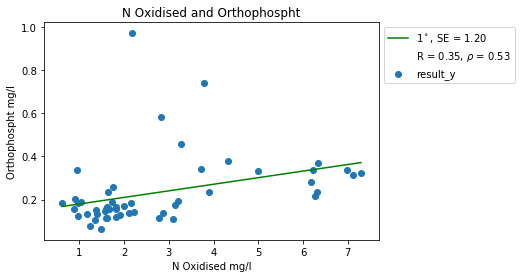

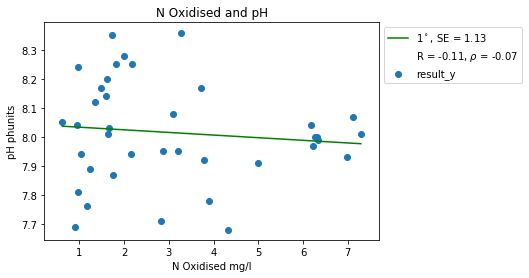

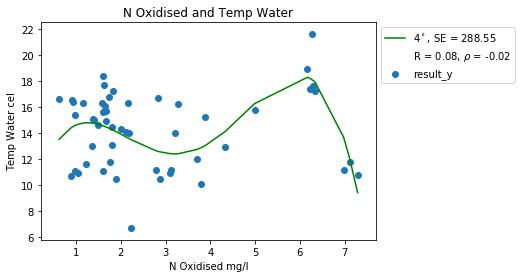

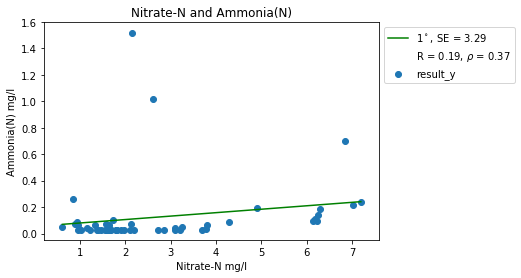

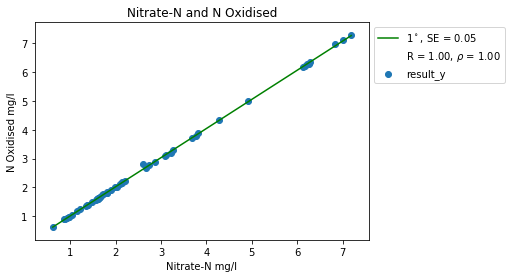

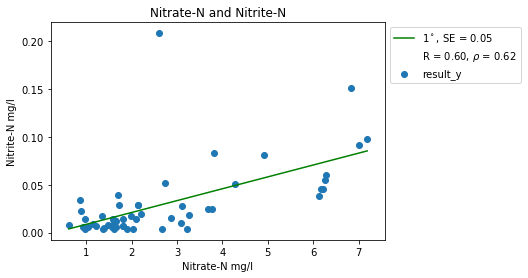

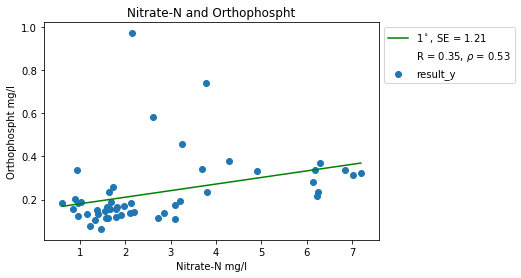

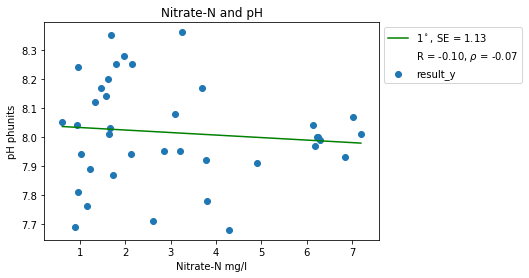

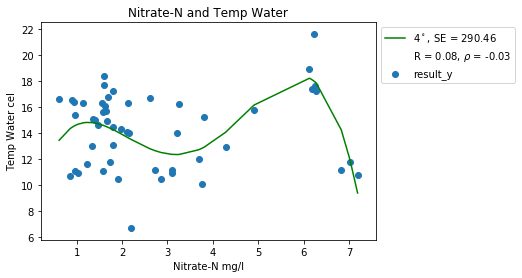

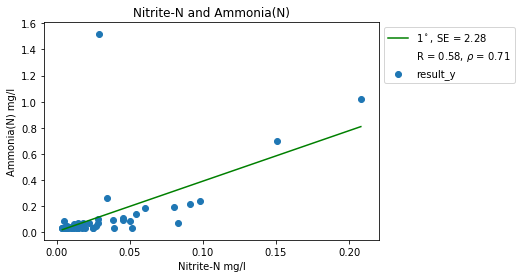

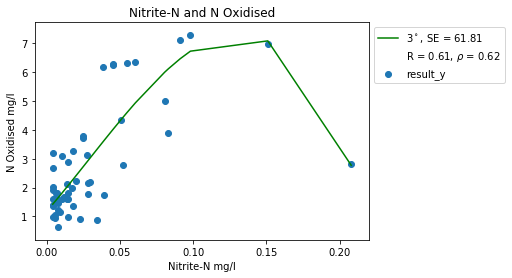

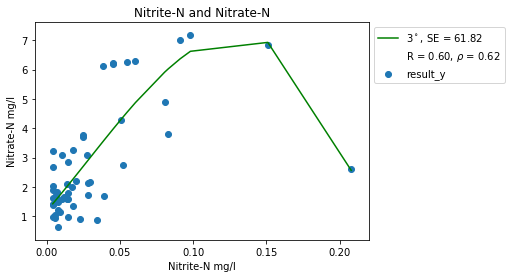

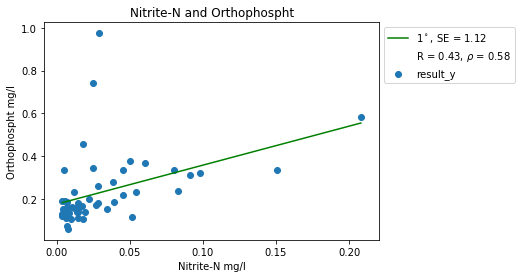

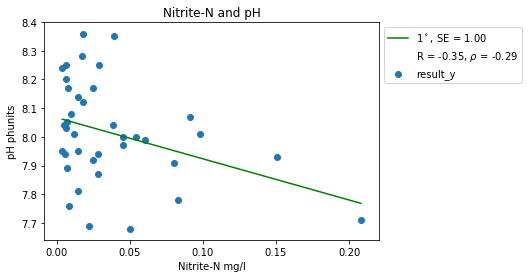

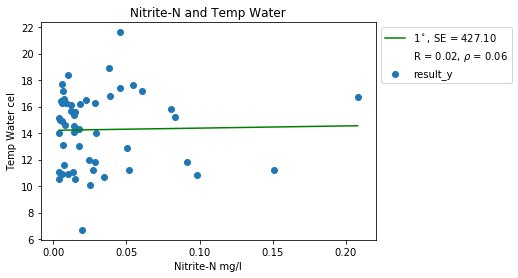

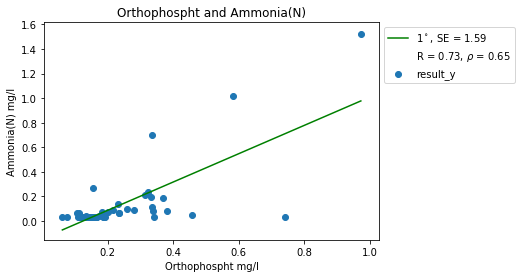

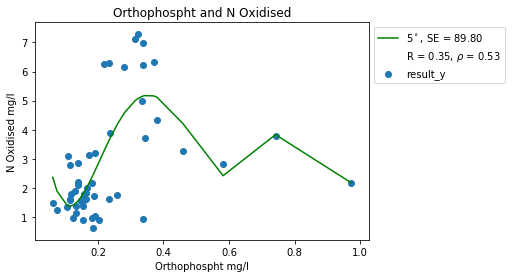

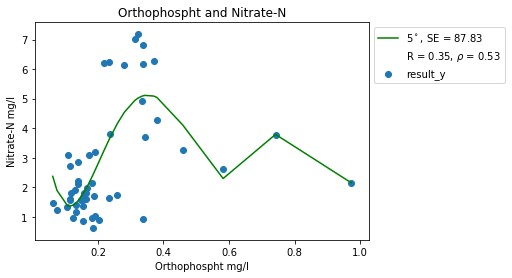

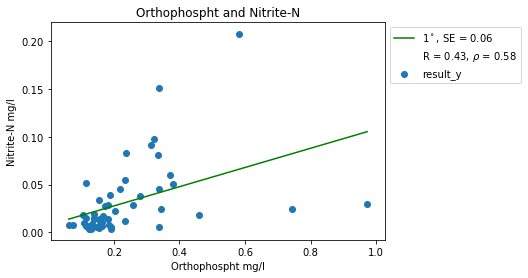

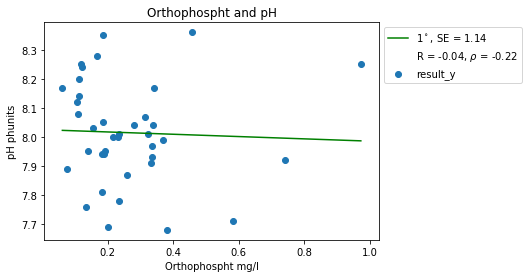

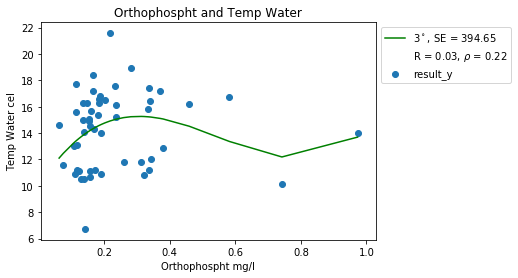

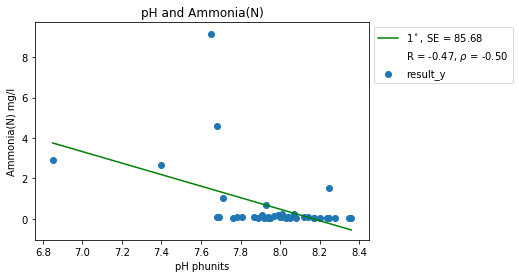

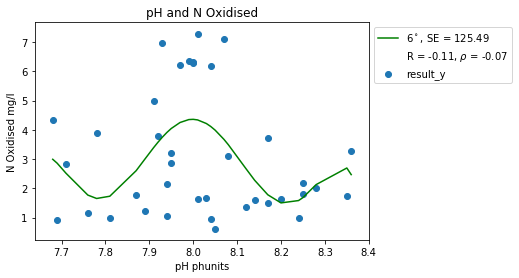

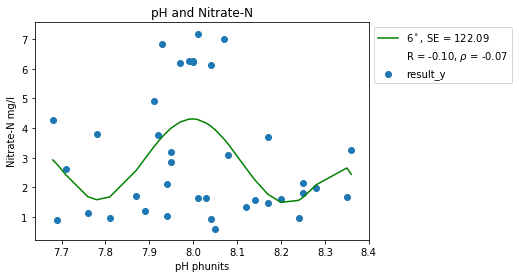

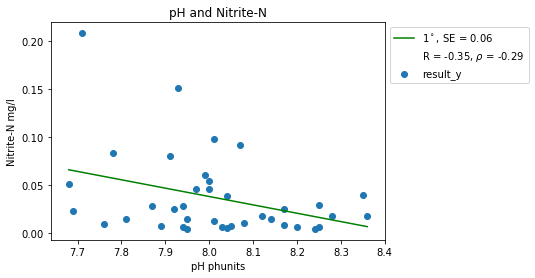

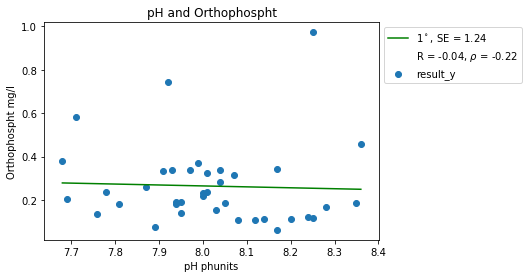

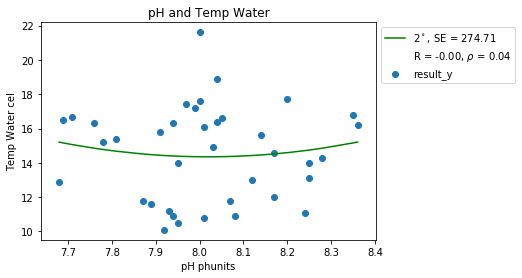

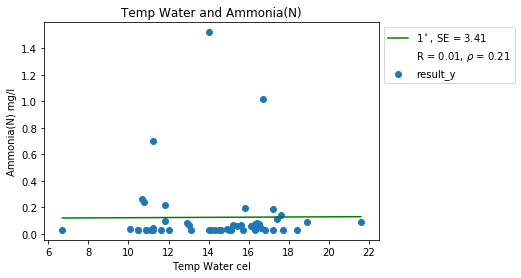

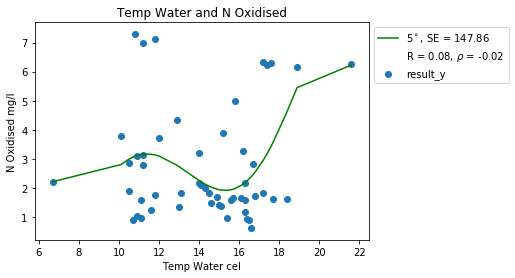

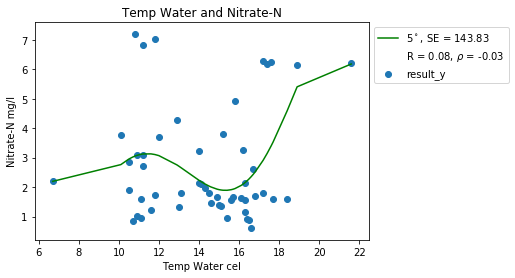

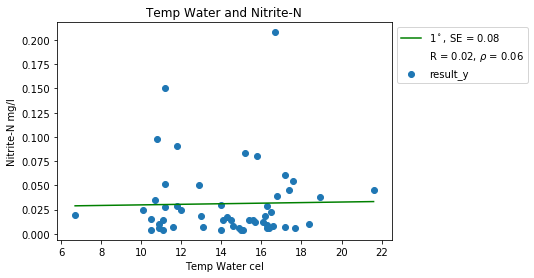

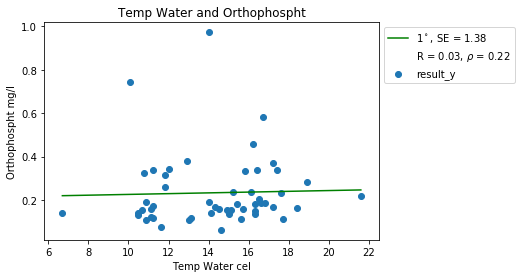

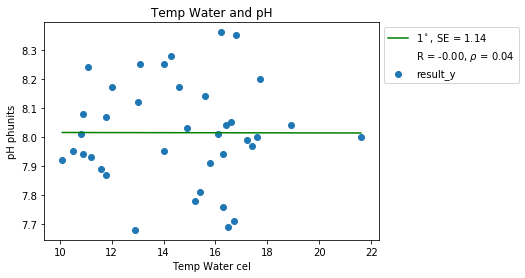

In [10]:
plt.show()
plt.gcf().clear() 